# Lab 8: Embeddings

***ในแล็บนี้เราจะศึกษา 3 วิธีในการแปลงคำให้เป็นเวกเตอร์ (Embeddings) คือ Bag-of-Words, TFIDF, และ Word2Vec***

Embeddings เป็นขั้นตอนการประมวลภาษาที่มีความสำคัญ เนื่องจากเป็นการแปลงข้อมูลคำ/ข้อความที่มนุษย์สามารถเข้าใจได้ให้อยู่ในรูปของเวกเตอร์ที่คอมพิวเตอร์สามารถเข้าใจได้แทน โดยที่ยังสามารถเก็บคุณลักษณะทางภาษาของคำ ๆ นั้นไว้ได้

**References**
1. https://github.com/datawiz-thailand/tutorials/tree/master
2. https://pythainlp.github.io/tutorials/notebooks/word2vec_examples.html
3. Charin Polpanumas, & Wannaphong Phatthiyaphaibun. (2021). thai2fit: Thai language Implementation of ULMFit (v0.3). Zenodo. https://doi.org/10.5281/zenodo.4429691

## 0. Install PyThaiNLP and Prepare Dataset

PyThaiNLP เป็นไลบรารี่สำหรับ Thai Natural Language Processing ที่ได้รับความนิยมสูง สามารถทำการติดตั้งได้ดังนี้

In [1]:
!pip install pythainlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 59.3 MB/s eta 0:00:00


ทำให้ Matplotlib แสดงภาษาไทยได้

In [2]:
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

In [3]:
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
mpl.rc('font', family='TH Sarabun New')

In [4]:
import pythainlp
import string
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

pythainlp.__version__

'4.0.1'

ข้อมูลตัวอย่างในแล็บนี้ เป็นข้อความบางส่วนจากข่าวในลิงก์นี้ https://workpointtoday.com/politic-mou-form-government/

In [5]:
text_list = ["ฟื้นฟูประชาธิปไตย รวมถึงการจัดทำรัฐธรรมนูญฉบับใหม่ของประชาชนให้เร็วที่สุด โดยมีสมาชิกสภาร่างรัฐธรรมนูญที่มาจากการเลือกตั้งโดยตรงของประชาชน",
             "ยืนยันและผ่านกฎหมายสมรสเท่าเทียม เพื่อรับประกันสิทธิสมรสสำหรับคู่รักทุกเพศ โดยจะไม่บังคับประชาชนที่เห็นว่าขัดแย้งกับหลักการของศาสนาที่ตนเองนับถือ",
             "ผลักดันการปฏิรูประบบราชการ ตำรวจ กองทัพ และกระบวนการยุติธรรม ให้สอดคล้องกับหลักประชาธิปไตย โดยยึดหลักความโปร่งใส ทันสมัย มีประสิทธิภาพ และผลประโยชน์สูงสุดของประชาชน",
             "เปลี่ยนการเกณฑ์ทหารแบบบังคับ เป็นระบบสมัครใจ ทั้งนี้ยังคงไว้ซึ่งการเกณฑ์ทหารในยามศึกสงคราม",
             "ร่วมผลักดันกระบวนการสร้างสันติภาพอย่างยั่งยืนในพื้นที่จังหวัดชายแดนภาคใต้ โดยคำนึงถึงหลักการด้านสิทธิมนุษยชน การอยู่ร่วมกันในสังคมพหุวัฒนธรรม การมีส่วนร่วมของทุกภาคส่วน รวมถึงทบทวนภารกิจของหน่วยงานและการบังคับใช้กฎหมายเกี่ยวกับความมั่นคง",
             "ผลักดันการกระจายอำนาจทั้งในแง่ภารกิจและงบประมาณ เพื่อให้ท้องถิ่นตอบสนองความต้องการของประชาชนในพื้นที่ได้อย่างเหมาะสม มีประสิทธิภาพ ปราศจากการทุจริต",
             "แก้ไขปัญหาการทุจริตคอร์รัปชันโดยการสร้างระบบและวัฒนธรรมรัฐโปร่งใส เปิดเผยข้อมูลรัฐในทุกหน่วยงาน",
             "ร่วมฟื้นฟูเศรษฐกิจ โดยยึดหลักเพิ่มรายได้ประชาชน ลดความเหลื่อมล้ำ และสร้างระบบเศรษฐกิจที่เติบโตอย่างเป็นธรรม",
             "ยกเครื่องกฎหมายเกี่ยวกับการทำมาหากิน และการดำรงชีวิตของประชาชน เช่น ตัด ลด หรือพักใช้ชั่วคราวซึ่งใบอนุมัติ อนุญาตที่ไม่จำเป็นและเป็นอุปสรรคเพื่อปรับปรุงใหม่ ให้ความช่วยเหลือสภาพคล่องทางด้านการเงินและสร้างแต้มต่อให้กับ SME พร้อมกับมุ่งเน้นการเติบโต GDP ของ SME สนับสนุนอุตสาหกรรม และสินค้าไทยให้มีความเข้มแข็ง สามารถแข่งขันกับตลาดโลกได้",
             "ยกเลิกการผูกขาดและส่งเสริมการแข่งขันทางการค้าที่เป็นธรรมในทุกอุตสาหกรรม เช่น เครื่องดื่มแอลกอฮอล์ โดยพรรคประชาชาติขอสงวนสิทธิในการไม่เห็นด้วยเฉพาะอุตสาหกรรมเครื่องแอลกอฮอล์ ด้วยเหตุผลทางด้านศาสนา",
             "ปฏิรูปที่ดินทั้งระบบ ด้วยการผลักดันกฎหมายปฏิรูปที่ดิน กระจายการถือครองที่ดินอย่างเป็นธรรม แก้ปัญหาแนวเขตป่าไม้และที่ดินของรัฐที่ทับซ้อนกับที่ดินของประชาชน รวมถึงการทบทวนคดีที่เป็นผลจากนโยบายทวงคืนผืนป่า",
             "ปรับปรุงโครงสร้างการผลิตไฟฟ้า การคำนวณราคา และกำลังการผลิตที่เหมาะสม เพื่อลดค่าครองชีพประชาชนและสร้างความมั่นคงทางพลังงาน",
             "จัดทำงบประมาณแบบใหม่ โดยเน้นใช้วิธีการจัดงบประมาณฐานศูนย์ (zero-based budgeting)",
             "สร้างระบบสวัสดิการดูแลประชาชนตั้งแต่เด็กแรกเกิดจนถึงผู้สูงวัย โดยคำนึงถึงความเหมาะสมและภาระทางการคลังระยะยาว",
             "แก้ไขปัญหายาเสพติด โดยเร่งด่วน",
             "นำกัญชากลับไปอยู่ในบัญชียาเสพติดให้โทษ โดยมีกฎหมายควบคุมและรองรับการใช้ประโยชน์กัญชา",
             "ส่งเสริมเกษตรและปศุสัตว์ปลอดภัย คุ้มครอง รักษาผลประโยชน์ของเกษตรกร ลดต้นทุนการผลิต ส่งเสริมการตลาด ส่งเสริมการเข้าถึงเทคโนโลยี และแหล่งน้ำ ส่งเสริมการรวมกลุ่มของเกษตรกรเพื่อวางแผนการผลิตและรักษาผลประโยชน์ของเกษตรกร ส่งเสริมอุตสาหกรรมแปรรูปผลผลิตทางการเกษตรเพื่อให้เกิดมูลค่าทางเศรษฐกิจ",
             "แก้ไขกฎหมายประมง ขจัดอุปสรรค เยียวยา ฟื้นฟู และพัฒนาอาชีพประมงให้ยั่งยืน",
             "ยกระดับสิทธิแรงงานทุกอาชีพให้มีสภาพการจ้างงานที่เป็นธรรม และได้รับค่าแรงที่เป็นธรรมสอดคล้องกับค่าครองชีพและการเติบโตทางเศรษฐกิจ",
             "ยกระดับระบบสาธารณสุข เพื่อทำให้ประชาชนเข้าถึงบริการสาธารสุขที่มีคุณภาพ ทั้งการส่งเสริม การป้องกัน การรักษา และการฟื้นฟูสุขภาพ",
             "ปฏิรูประบบการศึกษาเพื่อยกระดับคุณภาพ ลดความเหลื่อมล้ำ และส่งเสริมการเรียนรู้ตลอดชีวิต",
             "สร้างความร่วมมือและกลไกภายในและระหว่างประเทศ เพื่อแก้ปัญหาฝุ่นพิษ รวมถึงการลดการปล่อยก๊าซเรือนกระจกสุทธิให้เป็นศูนย์ (Net Zero) โดยเร็วที่สุด",
             "ดำเนินการนโยบายการต่างประเทศ โดยการฟื้นฟูบทบาทผู้นำของไทยในอาเซียน และรักษาสมดุลการเมืองระหว่างประเทศของไทยและประเทศมหาอำนาจ"
]

ทำการ Pre-Processing ด้วยการตัดคำในแต่ละประโยค

In [6]:
def split_word(text):
    for c in string.punctuation:
        text = text.replace(c, '')
    tokens = pythainlp.word_tokenize(text, engine='newmm')
    tokens = [i for i in tokens if not ' ' in i]
    return tokens

tokens_list = [split_word(txt) for txt in text_list]
tokens_str = [','.join(tkn) for tkn in tokens_list]

## 1. Bags of Words

ใช้วิธีการนำจำนวนครั้งที่คำที่กำหนดปรากฎในประโยค โดย 1 ประโยคจะถูกแทนด้วย 1 เวกเตอร์ ในทุก ๆ เวกเตอร์ สมาชิกแต่ละตำแหน่งจะแทนคำ 1 คำที่กำหนดไว้เหมือนกัน และค่าของสมาชิกคือจำนวนครั้งที่คำ ๆ นั้นปรากฎในประโยค 

ในตัวอย่างนี้ เราจะสนใจเฉพาะคำที่ปรากฎอย่างน้อยใน 2 ประโยค สามารถคำนวณได้ด้วยฟังก์ชัน [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(analyzer = lambda x:x.split(','), min_df=2)
c_feat = cvec.fit_transform(tokens_str)

ตัวอย่างเวกเตอร์ที่ได้ของ 2 ประโยคแรก โดยแสดงแค่สมาชิก 10 ตัวแรก

In [8]:
c_feat[:2,:10].todense()

matrix([[0, 0, 1, 0, 0, 2, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 0, 0, 0]])

คำที่กำหนดของ 10 ตำแหน่งแรกของเวกเตอร์

In [9]:
vocab = sorted(cvec.vocabulary_.items(), key=lambda x:x[1])
print([k for k, v in vocab[:10]])

['กฎหมาย', 'กับ', 'การ', 'การผลิต', 'การฟื้นฟู', 'ของ', 'ความมั่นคง', 'ความเหลื่อมล้ำ', 'คำนึงถึง', 'คุณภาพ']


จะเห็นว่าประโยคแรก มีคำว่า `ของ` ปรากฎ 2 ครั้ง และประโยคที่สองปรากฎ 1 ครั้ง และประโยคแรก มีคำว่า `กฎหมาย` ปรากฎ 0 ครั้ง และประโยคที่สองปรากฎ 1 ครั้ง

In [10]:
text_list[0]

'ฟื้นฟูประชาธิปไตย รวมถึงการจัดทำรัฐธรรมนูญฉบับใหม่ของประชาชนให้เร็วที่สุด โดยมีสมาชิกสภาร่างรัฐธรรมนูญที่มาจากการเลือกตั้งโดยตรงของประชาชน'

In [11]:
text_list[1]

'ยืนยันและผ่านกฎหมายสมรสเท่าเทียม เพื่อรับประกันสิทธิสมรสสำหรับคู่รักทุกเพศ โดยจะไม่บังคับประชาชนที่เห็นว่าขัดแย้งกับหลักการของศาสนาที่ตนเองนับถือ'

ทำการนับจำนวนครั้งที่แต่ละคำปรากฎ แล้วแสดงผล 10 คำที่ปรากฎบ่อยที่สุด

In [12]:
counts = {k:v for k, v in zip(cvec.vocabulary_, (c_feat.sum(axis=0)).tolist()[0])}
counts = dict(sorted(counts.items(), key=lambda x:x[1]))

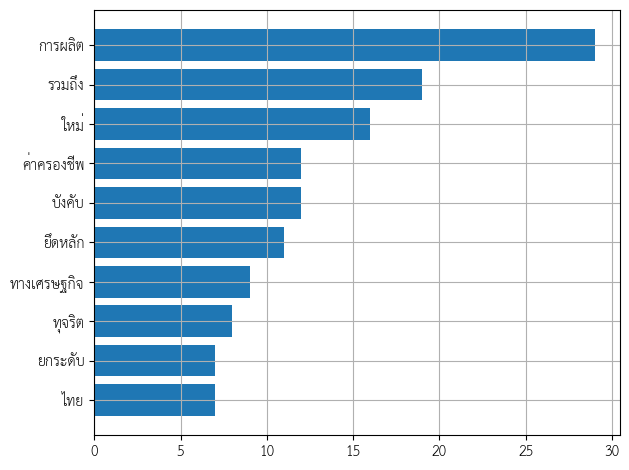

In [13]:
names = list(counts.keys())
values = list(counts.values())

plt.barh(range(10), values[-10:], tick_label=names[-10:])
plt.tight_layout()
plt.grid()
plt.show()

## TFIDF

Term Frequency - Inverse Document Frequency (TF-IDF) เป็นเทคนิคที่วัดความสำคัญของคำในประโยคในการแยกแยะ คำนวณค่าสมาชิกของเวกเตอร์โดยอิงจากความถี่ที่คำ ๆ นั้นปรากฎในประโยค (Term Frequency; TF) ที่ยิ่งปรากฎมากแปลว่ามีน้ำหนักหรือเกี่ยวข้องมาก และความถี่ที่ปรากกฎในประโยคต่าง ๆ (Document Frequency) ที่ยิ่งมากแปลว่าคำ ๆ นั้นเป็นคำทั่ว ๆ ไปที่ถูกใช้บ่อยครั้ง ไม่ได้บอกข้อมูลสำคัญอะไร ต่างจากคำที่ปรากฎในประโยคไม่กี่ประโยค ซึ่งอาจจะเป็นคำสำคัญ (Keyword) ก็เป็นได้

ในตัวอย่างนี้ เราจะสนใจเฉพาะคำที่ปรากฎอย่างน้อยใน 2 ประโยค สามารถคำนวณได้ด้วยฟังก์ชัน [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(analyzer=lambda x:x.split(','), min_df=2)
t_feat = tvec.fit_transform(tokens_str)

ตัวอย่างเวกเตอร์ที่ได้ของ 2 ประโยคแรก โดยแสดงแค่สมาชิก 10 ตัวแรก

In [15]:
t_feat[:2,:10].todense()

matrix([[0.        , 0.        , 0.16397339, 0.        , 0.        ,
         0.38128585, 0.        , 0.        , 0.        , 0.        ],
        [0.23585529, 0.25214334, 0.        , 0.        , 0.        ,
         0.1981679 , 0.        , 0.        , 0.        , 0.        ]])

คำที่กำหนดของ 10 ตำแหน่งแรกของเวกเตอร์

In [16]:
vocab = sorted(tvec.vocabulary_.items(), key=lambda x:x[1])
print([k for k, v in vocab[:10]])

['กฎหมาย', 'กับ', 'การ', 'การผลิต', 'การฟื้นฟู', 'ของ', 'ความมั่นคง', 'ความเหลื่อมล้ำ', 'คำนึงถึง', 'คุณภาพ']


แสดงค่า IDF ของคำตัวอย่าง 10 คำ

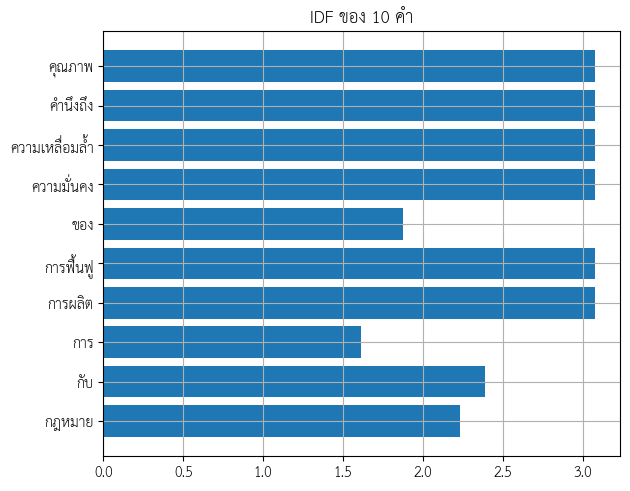

In [17]:
counts = {k:v for k, v in zip(dict(vocab).keys(), tvec.idf_)}

names = list(counts.keys())
values = list(counts.values())

plt.barh(range(10), tvec.idf_[:10], tick_label=names[:10])
plt.tight_layout()
plt.title('IDF ของ 10 คำ')
plt.grid()
plt.show()

# Word2Vec/Thai2Vec

ใช้เทคนิคการเรียนรู้ของเครื่อง (Machine Learning) ในการเรียนรู้โมเดลหรือฟังก์ชันที่แปลงคำเป็นเวกเตอร์ หรือที่เรียกว่า Word Embedding โดยมักจะใช้คลังคำศัพท์ขนาดใหญ่ (Corpus) ในการเรียนรู้/สร้างโมเดล อย่างโมเดลที่ใช้ในตัวอย่างนี้ คือ [Thai2Vec](https://github.com/cstorm125/thai2fit/) สร้างจาก Thai Wikipedia Dump ทำการโหลดโดยใช้ไลบรารี่ PyThaiNLP

In [18]:
from pythainlp import word_vector
import pandas as pd
wv = word_vector.WordVector(model_name="thai2fit_wv")
model = wv.get_model() # load thai2fit_wv from pythainlp

Corpus: thai2fit_wv
- Downloading: thai2fit_wv 0.1


  0%|          | 0/62452646 [00:00<?, ?it/s]

ลองหยิบ 10 คำแรกมาแสดงค่าเวกเตอร์ ในโมเดลนี้แต่ละคำจะถูกแปลงเป็นเวกเตอร์ขนาด 300 

In [19]:
thai2dict = {}
for word in model.index_to_key:
    thai2dict[word] = model[word]
thai2vec = pd.DataFrame.from_dict(thai2dict, orient='index')
thai2vec.head(10)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
ที่,0.308956,-0.097699,0.116745,0.215612,0.015768,-0.064163,0.062168,0.039649,0.864940,0.846904,...,-0.142418,0.033241,0.171581,-0.624864,-0.009358,0.449131,0.120130,-0.122195,-0.450617,-0.071318
และ,0.010751,-0.618971,0.129665,0.035460,-0.007560,0.027607,0.397824,0.026543,0.254075,0.168328,...,-0.105786,0.180930,-0.101630,0.070885,-0.037263,0.183606,-0.049088,-0.672288,-1.293044,0.592576
เป็น,-0.015736,-0.258926,0.052953,0.153728,-0.005985,-0.021081,0.041088,0.057312,1.633230,0.442729,...,-0.009408,-0.252576,-0.305512,0.372542,0.049151,0.568470,0.266586,0.400800,-0.784650,0.197369
ของ,-0.189711,-0.174774,0.171124,-0.186771,0.054294,-0.114150,-1.109456,-0.094466,-0.447015,0.042377,...,-0.168676,-0.148738,0.680404,0.097702,0.020270,0.182967,-0.083949,0.006287,-0.707434,-0.070234
มี,-0.156962,-0.231863,0.080312,0.323157,0.215695,0.055145,0.420794,0.016842,0.256759,0.832864,...,-0.044267,-0.147186,-0.105424,0.907078,0.009299,0.550953,0.139337,0.031696,-0.670379,-0.008048
ได้,-0.428813,-0.031194,0.041922,-0.036608,-0.008106,0.076470,-0.782270,0.033361,0.606864,0.440520,...,0.024458,-0.025031,0.103389,-0.078255,0.034323,0.459774,-0.748643,0.337775,-0.487408,-0.511535
"""""""""",-0.287710,0.064193,0.205076,0.146356,-0.071343,-0.039451,-1.845461,0.163763,1.018096,0.272786,...,0.051024,-0.532856,-0.131856,-0.090323,-0.058895,0.151262,-0.420358,0.055971,-0.930814,0.163908
การ,0.239587,-0.303620,0.079953,-0.453045,-0.528826,-0.161692,0.235725,-0.099673,0.691668,0.536159,...,-0.110436,-0.297495,-0.217414,0.045158,0.066647,0.190095,-0.304333,-0.724927,-0.995488,-0.716609
(,-0.120522,-0.355783,0.168180,-0.377733,-0.158624,-0.047249,0.361140,0.161460,0.913314,0.345037,...,0.116285,-0.318218,-0.356664,0.519889,0.130475,0.125772,0.101328,-0.382658,-1.205359,0.340139
),-0.086848,-0.155231,0.133015,-0.039913,0.183761,0.115142,-1.940854,-0.066565,-2.399744,0.146722,...,0.019406,-0.181474,0.099863,0.516092,0.201697,0.249139,0.252957,1.138815,-0.018209,0.232265


บางครั้งอาจเจอคำที่โมเดลไม่รู้จัก และไม่สามารถแปลงเป็นเวกเตอร์ได้ โมเดลก็จะไม่สนใจคำเหล่านั้น โดยเทคนิคนี้สามารถใช้ในการสรุปประโยคหรือเอกสารได้ เนื่องจากเวกเตอร์ของคำเหล่านี้บ่งบอกถึงความหมายของในรูปของชุดตัวเลข (บ่งบอกความหมายได้อย่างไร ให้เป็นการบ้านในการศึกษาค้นคว้า) ดังนั้นถ้าเอาเวกเตอร์ของทุกคำในประโยคมาเฉลี่ย ก็เป็นวิธีหนึ่งที่จะบอกใจความสำคัญของประโยคได้ โดยเราสามารถคำนวณเวกเตอร์ที่บ่งบอกใจความสำคัญของประโยคได้ด้วยฟังก์ชัน [`sentence_vectorizer`](https://pythainlp.github.io/dev-docs/api/word_vector.html#pythainlp.word_vector.WordVector.sentence_vectorizer)

In [20]:
sentence_vec = []
for txt in text_list:
    sentence_vec.append(wv.sentence_vectorizer(txt, use_mean=True))
sent_vec = np.array(sentence_vec).squeeze()

เมื่อคำนวณกับทุกประโยคแล้ว นำมาแสดงผลในจอ 2 มิติ โดยใช้เทคนิค [`T-SNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) ในการลดจำนวนมิติ/สมาชิกของเวกเตอร์จาก 300 ให้เหลือ 2 เพื่อที่จะแสดงบนกราฟได้

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 23 samples in 0.001s...
[t-SNE] Computed neighbors for 23 samples in 0.066s...
[t-SNE] Computed conditional probabilities for sample 23 / 23
[t-SNE] Mean sigma: 0.279392
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.703163
[t-SNE] KL divergence after 1000 iterations: 0.806997


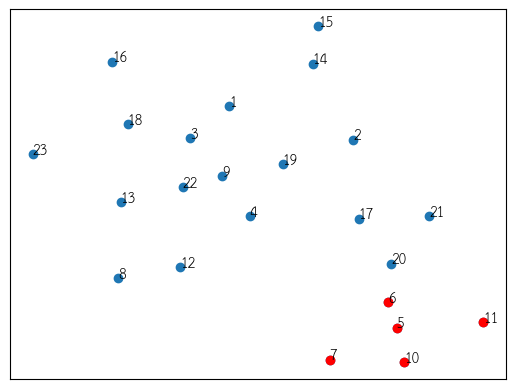

In [25]:
from sklearn.manifold import TSNE

# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=1, perplexity=3)
tsne_proj = tsne.fit_transform(sent_vec)

idx = [4, 5, 6, 9, 10]
plt.scatter(tsne_proj[:,0],tsne_proj[:,1])
plt.scatter(tsne_proj[idx,0],tsne_proj[idx,1], c='r')

for i in range(len(text_list)):
    plt.annotate(i+1, (tsne_proj[i,0], tsne_proj[i,1]))
plt.xticks([])
plt.yticks([])
plt.show()

แต่ละจุดในกราฟแทน 1 ประโยค ตัวเลขแทนลำดับของประโยค ลองสังเกตประโยคที่ไฮไลท์ด้วยสีแดง ซึ่งมีข้อความต่อไปนี้ จะเห็นได้ว่า ทั้ง 5 ประโยคพูดถึงเรื่องที่ใกล้เคียงกัน คือ เกี่ยวกับการแก้ปัญหาทุจริต สร้างความมั่นคง การกระจายอำนาจ เป็นต้น

In [24]:
for i in idx:
    print(i+1, text_list[i])

5 ร่วมผลักดันกระบวนการสร้างสันติภาพอย่างยั่งยืนในพื้นที่จังหวัดชายแดนภาคใต้ โดยคำนึงถึงหลักการด้านสิทธิมนุษยชน การอยู่ร่วมกันในสังคมพหุวัฒนธรรม การมีส่วนร่วมของทุกภาคส่วน รวมถึงทบทวนภารกิจของหน่วยงานและการบังคับใช้กฎหมายเกี่ยวกับความมั่นคง
6 ผลักดันการกระจายอำนาจทั้งในแง่ภารกิจและงบประมาณ เพื่อให้ท้องถิ่นตอบสนองความต้องการของประชาชนในพื้นที่ได้อย่างเหมาะสม มีประสิทธิภาพ ปราศจากการทุจริต
7 แก้ไขปัญหาการทุจริตคอร์รัปชันโดยการสร้างระบบและวัฒนธรรมรัฐโปร่งใส เปิดเผยข้อมูลรัฐในทุกหน่วยงาน
10 ยกเลิกการผูกขาดและส่งเสริมการแข่งขันทางการค้าที่เป็นธรรมในทุกอุตสาหกรรม เช่น เครื่องดื่มแอลกอฮอล์ โดยพรรคประชาชาติขอสงวนสิทธิในการไม่เห็นด้วยเฉพาะอุตสาหกรรมเครื่องแอลกอฮอล์ ด้วยเหตุผลทางด้านศาสนา
11 ปฏิรูปที่ดินทั้งระบบ ด้วยการผลักดันกฎหมายปฏิรูปที่ดิน กระจายการถือครองที่ดินอย่างเป็นธรรม แก้ปัญหาแนวเขตป่าไม้และที่ดินของรัฐที่ทับซ้อนกับที่ดินของประชาชน รวมถึงการทบทวนคดีที่เป็นผลจากนโยบายทวงคืนผืนป่า


----